In [ ]:
import pandas as pd
trades = pd.read_csv("/content/historical_data.csv", low_memory=False)
trades.info(); trades.head()
sentiment = pd.read_csv("/content/fear_greed_index.csv")
sentiment.info(); sentiment.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163296 entries, 0 to 163295
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           163296 non-null  object 
 1   Coin              163296 non-null  object 
 2   Execution Price   163296 non-null  float64
 3   Size Tokens       163296 non-null  float64
 4   Size USD          163296 non-null  float64
 5   Side              163296 non-null  object 
 6   Timestamp IST     163296 non-null  object 
 7   Start Position    163296 non-null  float64
 8   Direction         163296 non-null  object 
 9   Closed PnL        163296 non-null  float64
 10  Transaction Hash  163296 non-null  object 
 11  Order ID          163295 non-null  float64
 12  Crossed           163295 non-null  object 
 13  Fee               163295 non-null  float64
 14  Trade ID          163295 non-null  float64
 15  Timestamp         163295 non-null  float64
dtypes: float64(9), objec

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [ ]:
trades.columns = trades.columns.str.strip().str.lower().str.replace(" ", "_")
sentiment.columns = sentiment.columns.str.strip().str.lower().str.replace(" ", "_")


In [ ]:
print(trades.columns.tolist())


['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp']


In [ ]:
print(sentiment.columns.tolist())


['timestamp', 'value', 'classification', 'date']


In [ ]:
trades['timestamp_ist'] = pd.to_datetime(trades['timestamp_ist'], errors='coerce')
trades['start_position'] = pd.to_datetime(trades['start_position'], errors='coerce')

In [ ]:
sentiment['date'] = pd.to_datetime(sentiment['date'], errors='coerce')
sentiment['timestamp'] = pd.to_datetime(sentiment['timestamp'], errors='coerce')


In [ ]:
# Ensure both date columns are in date format for merging
trades['trade_date'] = pd.to_datetime(trades['timestamp_ist']).dt.date
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date

# Ensure both columns are datetime objects for merging
trades['trade_date'] = pd.to_datetime(trades['trade_date'])
sentiment['date'] = pd.to_datetime(sentiment['date'])

# Merge: left join keeps all trades, adds sentiment of that day
merged = trades.merge(sentiment[['date', 'classification', 'value']],
                      left_on='trade_date', right_on='date',
                      how='left')

In [ ]:
print(merged.head())
print(merged[['classification','closed_pnl']].groupby('classification').describe())


                                      account  coin  execution_price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   size_tokens  size_usd side       timestamp_ist  \
0       986.87   7872.16  BUY 2024-02-12 22:50:00   
1        16.00    127.68  BUY 2024-02-12 22:50:00   
2       144.09   1150.63  BUY 2024-02-12 22:50:00   
3       142.98   1142.04  BUY 2024-02-12 22:50:00   
4         8.73     69.75  BUY 2024-02-12 22:50:00   

                 start_position direction  closed_pnl  \
0 1970-01-01 00:00:00.000000000       Buy         0.0   
1 1970-01-01 00:00:00.000000986       Buy         0.0   
2 1970-01-01 00:00:00.000001002       Buy         0.0   
3 1970-01-01 00:00:0

In [ ]:
merged.groupby('classification')['closed_pnl'].mean()


,closed_pnl
classification,
Extreme Fear,7.055332
Extreme Greed,206.477543
Fear,145.866118
Greed,69.414287
Neutral,27.609742


In [ ]:
merged['profitable'] = merged['closed_pnl'] > 0
merged.groupby('classification')['profitable'].mean()


,profitable
classification,
Extreme Fear,0.352484
Extreme Greed,0.555060
Fear,0.395040
Greed,0.432721
Neutral,0.504438


In [ ]:
merged.groupby(['classification','side'])['closed_pnl'].mean()


classification  side
Extreme Fear    BUY       2.287015
                SELL     11.248483
Extreme Greed   BUY       9.047055
                SELL    289.666798
Fear            BUY     231.748973
                SELL     46.214368
Greed           BUY      41.893885
                SELL     94.271259
Neutral         BUY      12.484274
                SELL     36.771248
Name: closed_pnl, dtype: float64

In [ ]:
merged.groupby('classification')['size_usd'].mean()


,size_usd
classification,
Extreme Fear,4108.853810
Extreme Greed,3249.645849
Fear,6359.057488
Greed,5137.901740
Neutral,4361.694101


In [ ]:
merged.groupby(['account','classification'])['closed_pnl'].mean()


account                                     classification
0x083384f897ee0f19899168e3b1bec365f52a9012  Extreme Greed       0.000000
                                            Fear              502.539343
                                            Greed            -151.066687
0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd  Extreme Fear        0.000000
                                            Fear               11.443636
                                                                 ...    
0xbaaaf6571ab7d571043ff1e313a9609a10637864  Fear               10.633226
                                            Greed             252.845216
0xbee1707d6b44d4d52bfe19e41f8a828645437aab  Extreme Greed      98.975291
                                            Fear               74.908356
                                            Neutral            28.664860
Name: closed_pnl, Length: 102, dtype: float64

In [ ]:
print(merged.columns.tolist())


['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp', 'trade_date', 'date', 'classification', 'value', 'profitable']


In [ ]:
print(merged.head())


                                      account  coin  execution_price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   size_tokens  size_usd side       timestamp_ist  \
0       986.87   7872.16  BUY 2024-02-12 22:50:00   
1        16.00    127.68  BUY 2024-02-12 22:50:00   
2       144.09   1150.63  BUY 2024-02-12 22:50:00   
3       142.98   1142.04  BUY 2024-02-12 22:50:00   
4         8.73     69.75  BUY 2024-02-12 22:50:00   

                 start_position direction  closed_pnl  ...      order_id  \
0 1970-01-01 00:00:00.000000000       Buy         0.0  ...  5.201771e+10   
1 1970-01-01 00:00:00.000000986       Buy         0.0  ...  5.201771e+10   
2 1970-01-01 00:00:0

In [ ]:
print(trades['timestamp'].head())
print(trades['timestamp'].dtype)

0    1.730000e+12
1    1.730000e+12
2    1.730000e+12
3    1.730000e+12
4    1.730000e+12
Name: timestamp, dtype: float64
float64


In [ ]:
print("Trades Date Range:", trades['trade_date'].min(), trades['trade_date'].max())
print("Sentiment Date Range:", sentiment['date'].min(), sentiment['date'].max())

Trades Date Range: 2023-01-05 00:00:00 2025-12-04 00:00:00
Sentiment Date Range: 2018-02-01 00:00:00 2025-05-02 00:00:00


In [ ]:
print(merged['trade_date'].head())
print(sentiment['date'].head())

0   2024-02-12
1   2024-02-12
2   2024-02-12
3   2024-02-12
4   2024-02-12
Name: trade_date, dtype: datetime64[ns]
0   2018-02-01
1   2018-02-02
2   2018-02-03
3   2018-02-04
4   2018-02-05
Name: date, dtype: datetime64[ns]


In [ ]:
# Drop one of them (keep 'Date')
merged = merged.drop(columns=["trade_date"])


In [ ]:
print(merged["date"].isnull().sum())
print(merged["classification"].isnull().sum())
print(merged["value"].isnull().sum())


131822
131822
131822


In [ ]:
merged = merged.dropna()


In [ ]:
print(merged.isnull().sum())
print(len(merged))


account             0
coin                0
execution_price     0
size_tokens         0
size_usd            0
side                0
timestamp_ist       0
start_position      0
direction           0
closed_pnl          0
transaction_hash    0
order_id            0
crossed             0
fee                 0
trade_id            0
timestamp           0
date                0
classification      0
value               0
profitable          0
dtype: int64
31474


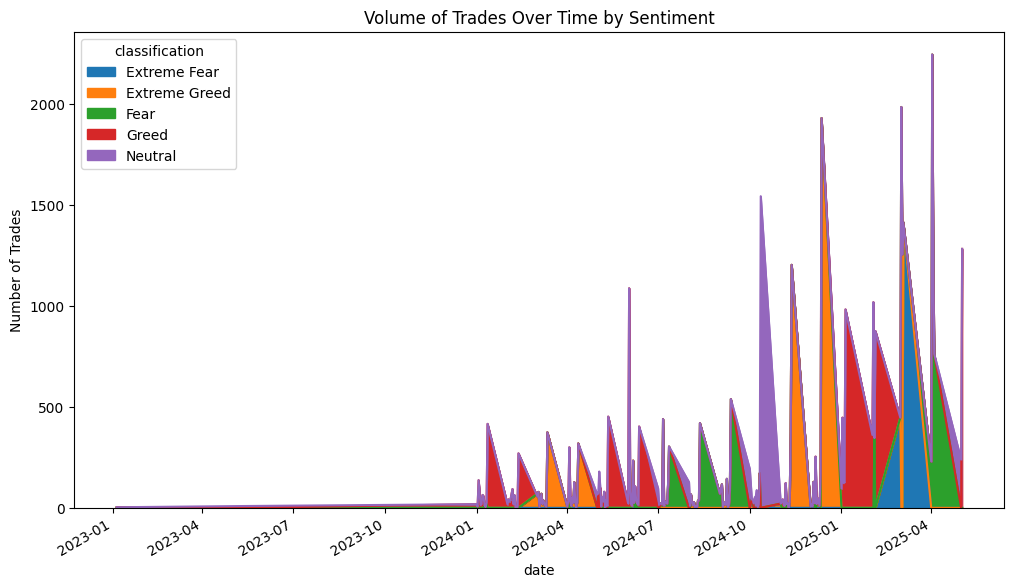

In [ ]:
import matplotlib.pyplot as plt

# Prepare daily trade counts
daily_trades = merged.copy()
daily_trades['classification'] = daily_trades['classification'].fillna('Unknown')


volume_by_day = daily_trades.groupby(['date','classification']).size().unstack(fill_value=0)

# Plot stacked area
volume_by_day.plot(kind='area', stacked=True, figsize=(12,7))
plt.title("Volume of Trades Over Time by Sentiment")
plt.ylabel("Number of Trades")
plt.show()

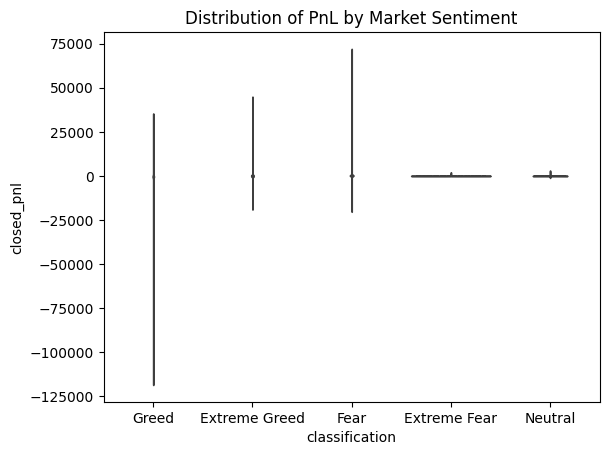

In [ ]:
import seaborn as sns
sns.violinplot(x='classification', y='closed_pnl', data=daily_trades, inner='quartile')
plt.title("Distribution of PnL by Market Sentiment")
plt.show()

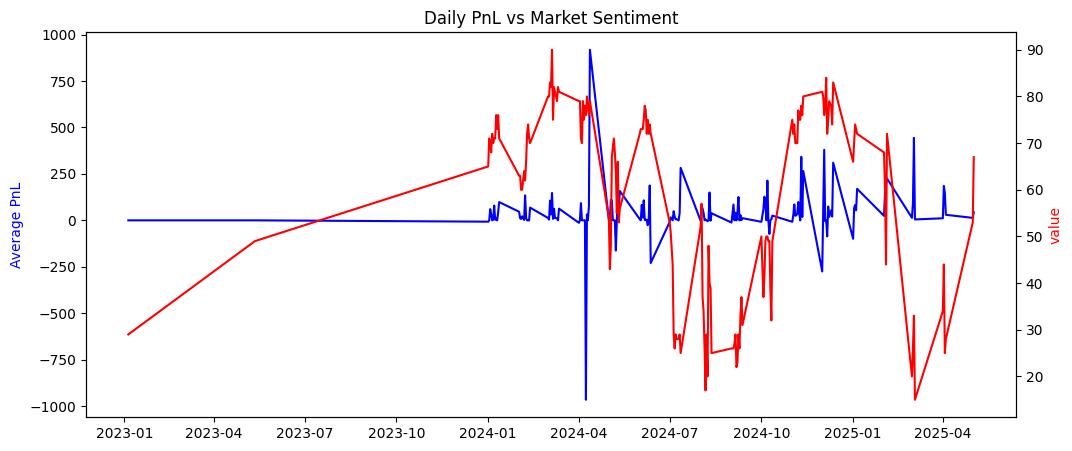

In [ ]:
import matplotlib.pyplot as plt

# Resample daily average PnL + sentiment
daily = merged.groupby("date").agg({
    "closed_pnl": "mean",
    "value": "mean"
}).reset_index()

fig, ax1 = plt.subplots(figsize=(12,5))

# Plot Avg PnL
ax1.plot(daily["date"], daily["closed_pnl"], color="blue", label="Avg PnL")
ax1.set_ylabel("Average PnL", color="blue")

# Twin axis for sentiment
ax2 = ax1.twinx()
ax2.plot(daily["date"], daily["value"], color="red", label="value")
ax2.set_ylabel("value", color="red")

plt.title("Daily PnL vs Market Sentiment")
plt.show()

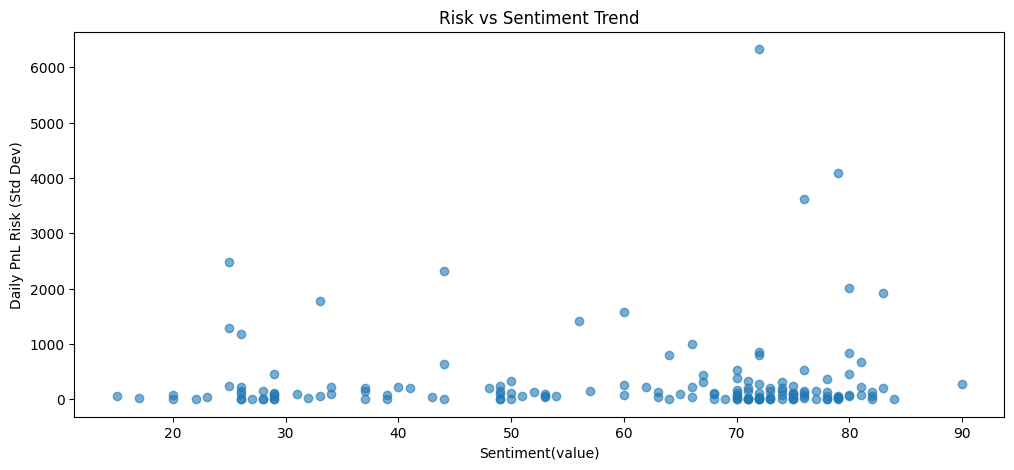

In [ ]:
risk_daily = merged.groupby("date").agg({
    "closed_pnl": "std",
    "value": "mean"
}).reset_index()

plt.figure(figsize=(12,5))
plt.scatter(risk_daily["value"], risk_daily["closed_pnl"], alpha=0.6)
plt.xlabel("Sentiment(value)")
plt.ylabel("Daily PnL Risk (Std Dev)")
plt.title("Risk vs Sentiment Trend")
plt.show()


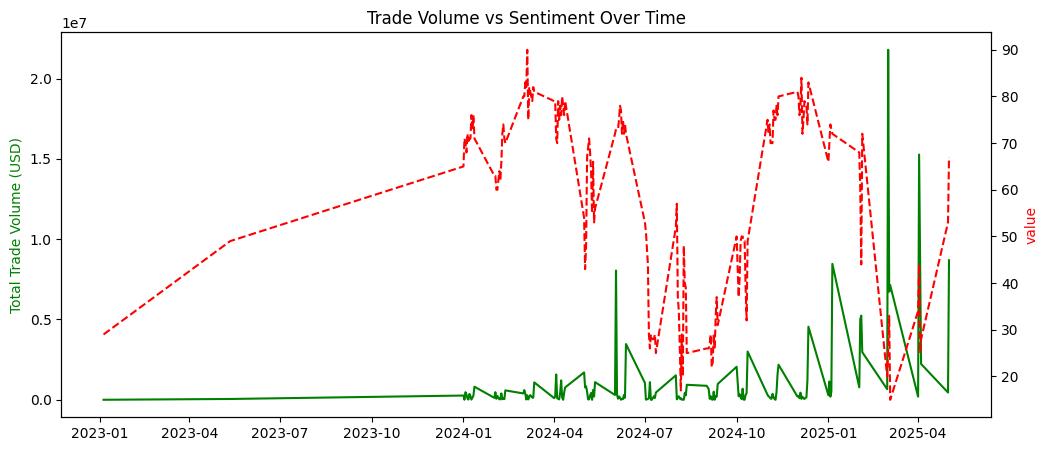

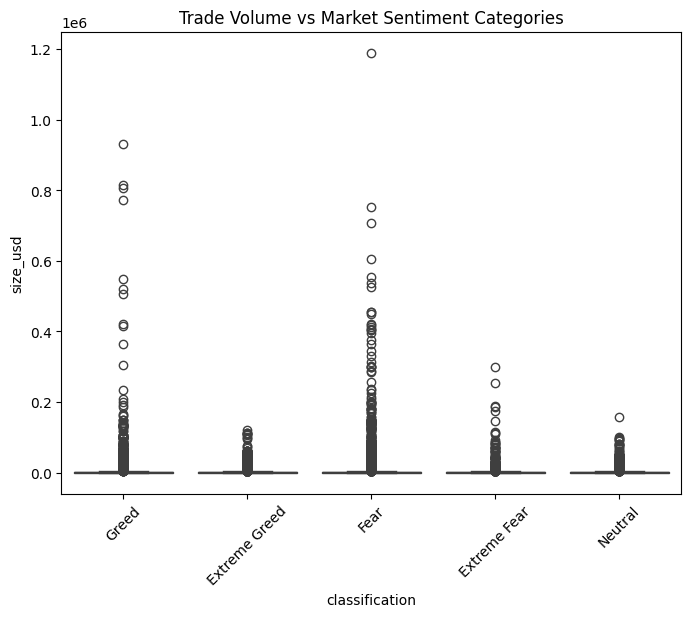

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Group data by date for time-series analysis ---
daily_vol = merged.groupby("date").agg({
    "size_usd": "sum",    # total daily trade volume
    "value": "mean"       # average sentiment value
}).reset_index()

# --- Step 2: Plot Trade Volume vs Sentiment Over Time ---
fig, ax1 = plt.subplots(figsize=(12,5))

ax1.plot(daily_vol["date"], daily_vol["size_usd"], color="green", label="Total Trade Volume")
ax1.set_ylabel("Total Trade Volume (USD)", color="green")

ax2 = ax1.twinx()
ax2.plot(daily_vol["date"], daily_vol["value"], color="red", linestyle="--", label="value")
ax2.set_ylabel("value", color="red")

plt.title("Trade Volume vs Sentiment Over Time")
plt.show()

# --- Step 3: Trade Volume vs Market Sentiment Categories ---
plt.figure(figsize=(8,6))
sns.boxplot(x="classification", y="size_usd", data=merged)
plt.title("Trade Volume vs Market Sentiment Categories")
plt.xticks(rotation=45)
plt.show()


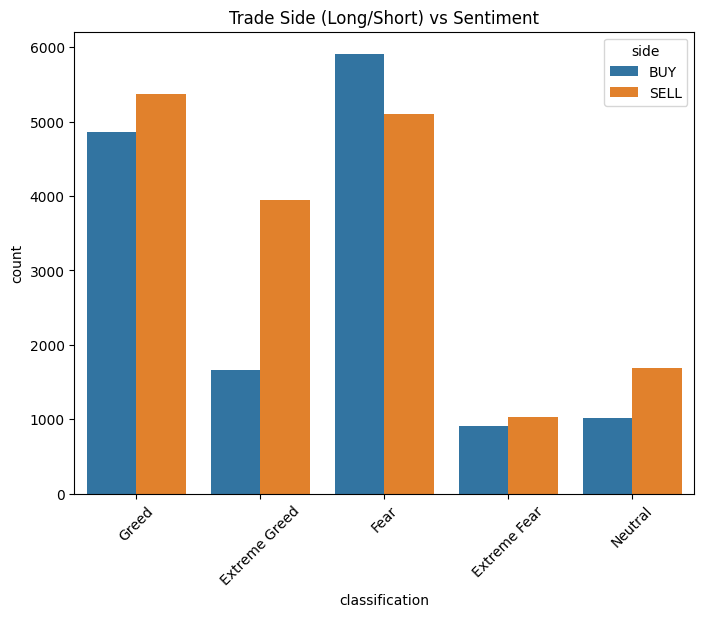

In [ ]:
#Trade Direction (Long/Short) Counts per Sentiment
plt.figure(figsize=(8,6))
sns.countplot(x="classification", hue="side", data=merged)
plt.title("Trade Side (Long/Short) vs Sentiment")
plt.xticks(rotation=45)
plt.show()

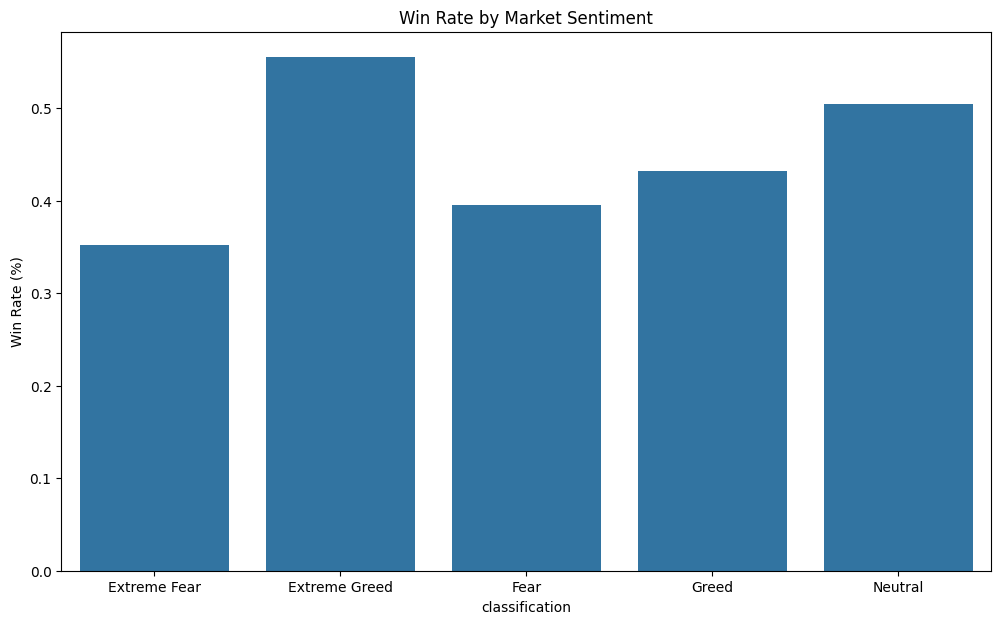

In [ ]:
daily_trades['profitable'] = daily_trades['closed_pnl'] > 0
winrate = daily_trades.groupby('classification')['profitable'].mean().reset_index()

plt.figure(figsize=(12,7))
sns.barplot(x='classification', y='profitable', data=winrate)
plt.title("Win Rate by Market Sentiment")
plt.ylabel("Win Rate (%)")
plt.show()

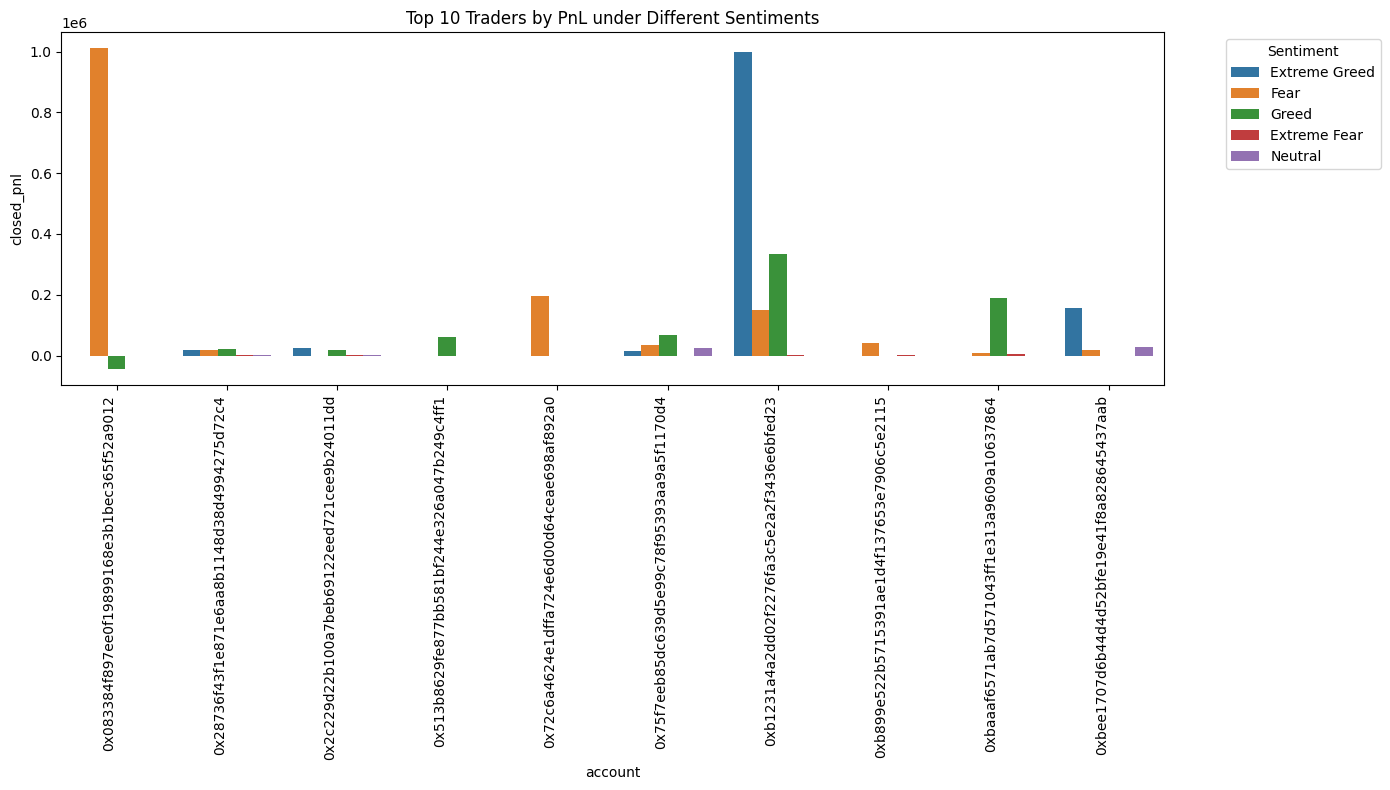

In [ ]:
top_traders = (daily_trades.groupby(['account','classification'])['closed_pnl']
               .sum().reset_index())

# Pick top 10 by total PnL
top10 = (top_traders.groupby('account')['closed_pnl'].sum()
         .nlargest(10).index)

plt.figure(figsize=(14, 8))
sns.barplot(x='account', y='closed_pnl', hue='classification',
            data=top_traders[top_traders['account'].isin(top10)])
plt.title("Top 10 Traders by PnL under Different Sentiments")
plt.xticks(rotation=90, ha='right')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

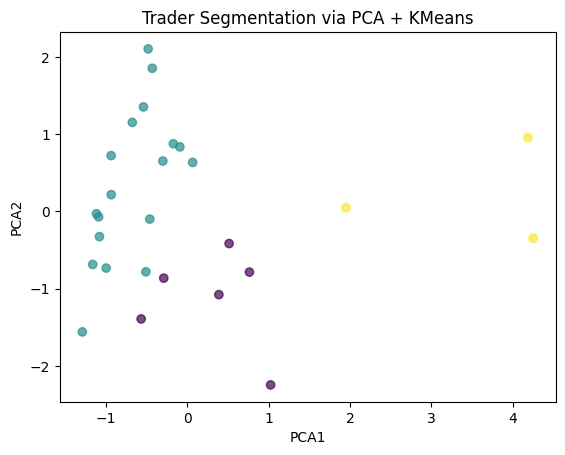

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Build features per trader
features = daily_trades.groupby('account').agg({
    'closed_pnl':['mean','std'],
    'profitable':'mean',
    'size_usd':'mean'
}).fillna(0)
features.columns = ['pnl_mean','pnl_volatility','winrate','avg_size']

# Scale + PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Cluster
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Plot clusters
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='viridis', alpha=0.7)
plt.title("Trader Segmentation via PCA + KMeans")
plt.xlabel("PCA1"); plt.ylabel("PCA2")
plt.show()


In [ ]:
#Machine Learning: Predicting Trade Success
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Step 1: Create target variable (1 = Profit, 0 = Loss)
merged['profitable'] = (merged['closed_pnl'] > 0).astype(int)

# Step 2: Encode categorical features
le = LabelEncoder()
merged['sentiment_code'] = le.fit_transform(merged['classification'])  # Fear=0, Greed=1, Neutral=2

# Step 3: Select features
X = merged[['execution_price', 'size_tokens', 'size_usd', 'fee', 'sentiment_code']]
y = merged['profitable']

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 5: Train Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Step 6: Predictions
y_pred = model.predict(X_test)

# Step 7: Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[5249   45]
 [4123   26]]

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.99      0.72      5294
           1       0.37      0.01      0.01      4149

    accuracy                           0.56      9443
   macro avg       0.46      0.50      0.36      9443
weighted avg       0.47      0.56      0.41      9443



Random Forest Accuracy: 0.8526951180768824


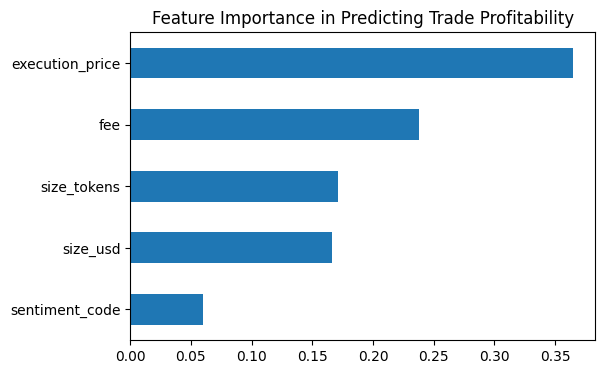

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

print("Random Forest Accuracy:", rf.score(X_test, y_test))

# Feature Importance
feat_imp = pd.Series(rf.feature_importances_, index=X.columns)
feat_imp.sort_values().plot(kind="barh", figsize=(6,4))
plt.title("Feature Importance in Predicting Trade Profitability")
plt.show()


In [ ]:
merged.to_excel("/content/drive/MyDrive/ds_praful_sasane/csv_files/merged_trades_sentiment.xlsx", index=False)
